In [2]:
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from findpeaks import findpeaks
from scipy.signal import get_window
from skimage.filters import median
from skimage.morphology import square
from skimage.transform import resize
from statsmodels.api import OLS, add_constant


# Experiment: Modified v1 One-Shot

## Objective
The goal of this experiment is to analyze an image from the Modified v1 One-Shot experiment and fit a mathematical function to the data.



## Workflow
1. **Load the Image**  
    Import the image from the Modified v1 One-Shot experiment for analysis.

2. **Preprocess the Image**  
    - Convert the image to grayscale (if necessary).  
    - Normalize the pixel values.  
    - Extract relevant data points for fitting.

3. **Define the Function**  
    Choose a mathematical function (e.g., linear, polynomial, Gaussian) to fit the data.

4. **Fit the Function**  
    - Use curve fitting techniques (e.g., `scipy.optimize.curve_fit`) to fit the function to the data.  
    - Evaluate the goodness of fit using metrics like R-squared.

5. **Visualize the Results**  
    - Plot the original data points.  
    - Overlay the fitted function for comparison.

6. **Analyze and Interpret**  
    - Discuss the results of the fit.  
    - Highlight any patterns or anomalies observed.



## Next Steps
- Refine the fitting process if necessary.  
- Explore alternative functions for better accuracy.  
- Document findings and prepare for further experiments.

In [7]:
def apply_normalization(pattern):
        pattern_normalized = (pattern - pattern.min()) / (pattern.max() - pattern.min())
        return pattern_normalized.astype(np.float32)

In [8]:
def apply_median_blur(pattern, kernel_size=5):
    # TODO: Optimize this implementation, rather slow for kernel size = 25 pixels
    #       Options:
    #       1. Swap for Gaussian blur
    #       2. Operate on uint images with optimized rank or OpenCV2 implementation
    #
    #       Note: I prefer to keep consistency (i.e. only use scikit-image as backend)
    square_kernel = square(kernel_size)
    blurred_pattern = median(pattern, square_kernel)
    return blurred_pattern

In [9]:
def apply_crop(pattern,
                roi_height,
                roi_width="auto",
                roi_offset_height=0,
                roi_offset_width=0):
    height, width = pattern.shape
    center_h = height // 2
    center_w = width // 2

    if roi_width == "auto":
        roi_width = width

    start_h = max(0, center_h - roi_height // 2 + roi_offset_height)
    end_h = min(height, start_h + roi_height)

    start_w = max(0, center_w - roi_width // 2 + roi_offset_width)
    end_w = min(width, start_w + roi_width)

    cropped_pattern = pattern[start_h:end_h, start_w:end_w]
    return cropped_pattern

In [10]:
def apply_aggregate_roi(pattern):
    return pattern.mean(axis=0)

In [12]:
def apply_window(signal, option="hann"):
    window = get_window(option, signal.size)
    return signal * window

In [13]:
def apply_padding(signal, resolution_multiplier=2):
    original_length = len(signal)
    target_length = int(original_length * resolution_multiplier)

    total_padding = target_length - original_length
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding

    padded_signal = np.pad(
        signal, (left_padding, right_padding),
        mode='constant', constant_values=0
    )
    return padded_signal

In [14]:
def apply_clipping(signal):
    return np.clip(signal, 0, 1)

Array shape: (1024, 1280)
Array dtype: uint8


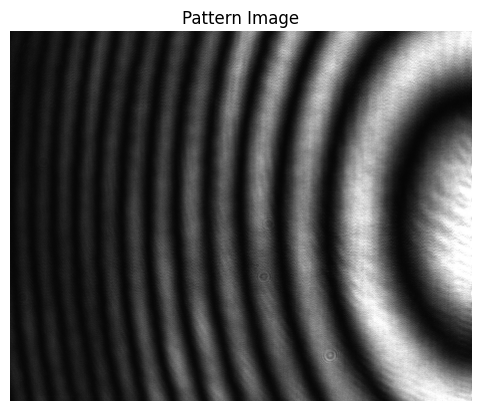

In [23]:
# Convert the image to a NumPy array
pattern_array = np.array(pattern_image)

# Display basic information about the array
print(f"Array shape: {pattern_array.shape}")
print(f"Array dtype: {pattern_array.dtype}")

plt.imshow(pattern_array, cmap='gray')
plt.title("Pattern Image")
plt.axis('off')
plt.show()

In [52]:
def preprocess_pattern(pattern):
    blur_kernel_size = 15  # Define a default kernel size for median blur
    roi_height = 100  # Define a default height for the region of interest
    window_option = "hann"  # Define a default window option
    resolution_multiplier = 2  # Define a default resolution multiplier
    
    # pattern = apply_horizontal_flip(pattern)
    # pattern = apply_interpolate_to_square_shape(pattern)  # max(H, W)

    pattern = apply_normalization(pattern)  # [0, 1] float32
    pattern = apply_median_blur(pattern, kernel_size=blur_kernel_size)
    pattern = apply_crop(pattern, roi_height=roi_height)
    signal = apply_aggregate_roi(pattern)  # mean over vertical axis (axis=0)
    #signal = pattern

    #signal = apply_window(signal, option=window_option)
    #signal = apply_padding(signal, resolution_multiplier=resolution_multiplier)
    #signal = apply_clipping(signal)
    return signal

Array shape: (100, 1280)
Array dtype: float32


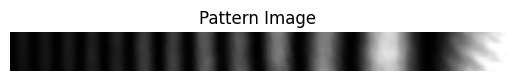

In [ ]:
# new = preprocess_pattern(pattern_array)
# print(f"Array shape: {new.shape}")
# print(f"Array dtype: {new.dtype}")

# plt.imshow(new, cmap='gray')
# plt.title("Pattern Image")
# plt.axis('off')
# plt.show()

In [53]:
new = preprocess_pattern(pattern_array)
print(new)
print(f"Array shape: {new.shape}")
print(f"Array dtype: {new.dtype}")

[0.03203921 0.03184313 0.03196077 ... 0.99600005 0.9952158  0.99411774]
Array shape: (1280,)
Array dtype: float32


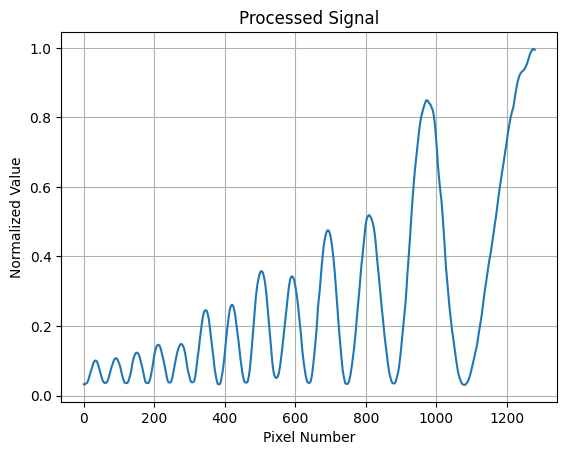

In [55]:
plt.plot(new)
plt.title("Processed Signal")
plt.xlabel("Index")
plt.ylabel("Normalized Value")
plt.xlabel("Pixel Number")
plt.grid(True)
plt.show()